In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
from keras import optimizers

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mean_squared_error
from keras import layers as KL

import uproot
import numpy
import matplotlib.pyplot
import pandas as pd
from pathlib import Path

from keras.layers import Input, Dense, Lambda, Layer, LeakyReLU, ReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, BaseLogger, \
TerminateOnNaN, Callback, ModelCheckpoint, LambdaCallback

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from keras.constraints import max_norm
# from sklearn.externals.joblib import dump, load

from numpy.random import seed
import time

import json
import pickle
import os
import shutil

import random as rn

np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

# import ray
# from ray.tune.integration.keras import TuneReporterCallback
# from ray import tune
# from ray.tune.schedulers import AsyncHyperBandScheduler, ASHAScheduler, PopulationBasedTraining
import random
import csv

from config import *
from vae_utility import *

In [19]:
original_dim = 3

latent_dim = 3
intermediate_dim = 50
kernel_max_norm = 500.
act_fun = 'relu'
weight_KL_loss = 0.6

Nf_lognorm = 3
Nf_PDgauss = 0

In [20]:
def KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior):
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return 0.5 * K.sum(kl_loss, axis=-1)

#######################################################################
def RecoProb_forVAE(x, par1, par2, par3, w):

    N = 0
    nll_loss = 0

    if Nf_lognorm != 0:

        for i in range(Nf_lognorm):

            #Log-Normal distributed variables
            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            fraction = par3[:,i:i+1]
            x_clipped = K.clip(x[:,i:i+1], clip_x_to0, 1e8)
            single_NLL = K.tf.where(K.less(x[:,i:i+1], clip_x_to0),
                                    -K.log(fraction),
                                        -K.log(1-fraction)
                                        + K.log(sigma)
                                        + K.log(x_clipped)
                                        + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

        N += Nf_lognorm

    if Nf_PDgauss != 0:

        for i in range(N, N+Nf_PDgauss):

            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            norm_xp = K.tf.divide(x[:,i:i+1] + 0.5 - mu, sigma)
            norm_xm = K.tf.divide(x[:,i:i+1] - 0.5 - mu, sigma)
            sqrt2 = 1.4142135624
            single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

            norm_0 = K.tf.divide(-0.5 - mu, sigma)
            aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
            single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

    return nll_loss


def IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,:1]
    sigma = par2[:,:1]
    fraction = par3[:,:1]
    x_clipped = K.clip(x[:,:1], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:1], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,1:2]
    sigma = par2[:,1:2]
    fraction = par3[:,1:2]
    x_clipped = K.clip(x[:,1:2], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,1:2], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,2:3]
    sigma = par2[:,2:3]
    fraction = par3[:,2:3]
    x_clipped = K.clip(x[:,2:3], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,2:3], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_4(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,3:4]
    sigma = par2[:,3:4]
    fraction = par3[:,3:4]
    x_clipped = K.clip(x[:,3:4], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,3:4], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_5(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,4:5]
    sigma = par2[:,4:5]
    fraction = par3[:,4:5]
    x_clipped = K.clip(x[:,4:5], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,4:5], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss


def individualRecoProb_forVAE_discrete_6(x, par1, par2, w):
    nll_loss = 0

    mu = par1[:,5:6]
    sigma = par2[:,5:6]
    norm_xp = K.tf.divide(x[:,5:6] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,5:6] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss


def individualRecoProb_forVAE_discrete_7(x, par1, par2, w):
    nll_loss = 0

    mu = par1[:,6:7]
    sigma = par2[:,6:7]
    norm_xp = K.tf.divide(x[:,6:7] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,6:7] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

In [21]:
class CustomKLLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomKLLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        mu, sigma, mu_prior, sigma_prior = inputs
        return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior)


class CustomRecoProbLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomRecoProbLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return RecoProb_forVAE(x, par1, par2, par3, w = w)

#################################################################################################à
class CustomIndividualLogNorLayer_1(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_1, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w = ind_w[0])

class CustomIndividualLogNorLayer_2(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_2, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w = ind_w[1])


class CustomIndividualLogNorLayer_3(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_3, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w = ind_w[2])

class CustomIndividualLogNorLayer_4(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_4, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_4(x, par1, par2, par3, w = ind_w[3])

class CustomIndividualLogNorLayer_5(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_5, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_5(x, par1, par2, par3, w = ind_w[4])

#         class CustomIndividualLogNorLayer_6(Layer):
#             def __init__(self, **kwargs):
#                 self.is_placeholder = True
#                 super(CustomIndividualLogNorLayer_6, self).__init__(**kwargs)

#             def call(self, inputs):
#                 x, par1, par2, par3 = inputs
#                 return IndividualRecoProb_forVAE_lognorm_6(x, par1, par2, par3, w = ind_w[5])

class CustomIndividualTruGauLayer_6(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualTruGauLayer_6, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2 = inputs
        return individualRecoProb_forVAE_discrete_6(x, par1, par2, w = ind_w[5])

class CustomIndividualTruGauLayer_7(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualTruGauLayer_7, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2 = inputs
        return individualRecoProb_forVAE_discrete_7(x, par1, par2, w = ind_w[6])

In [22]:
from keras.models import load_model
custom_objects = {
    'original_dim': 3,
    'latent_dim': latent_dim,
    'intermediate_dim': intermediate_dim,
    'act_fun': act_fun,
    'Nf_lognorm' : Nf_lognorm,
    'CustomKLLossLayer' : CustomKLLossLayer,
    'CustomRecoProbLayer' : CustomRecoProbLayer,
    
    'CustomIndividualLogNorLayer_1' : CustomIndividualLogNorLayer_1,
    'CustomIndividualLogNorLayer_2' : CustomIndividualLogNorLayer_2,
    'CustomIndividualLogNorLayer_3' : CustomIndividualLogNorLayer_3,
#     'CustomIndividualLogNorLayer_4' : CustomIndividualLogNorLayer_4,
#     'CustomIndividualLogNorLayer_5' : CustomIndividualLogNorLayer_5,
#     'CustomIndividualLogNorLayer_6' : CustomIndividualLogNorLayer_6,
    
#     'CustomIndividualTruGauLayer_7' : CustomIndividualTruGauLayer_6,
#     'CustomIndividualTruGauLayer_8' : CustomIndividualTruGauLayer_7,

#     'metric' :metric,
    'IdentityLoss' : IdentityLoss
}

In [23]:
weight_KL_loss = 0.6

path = 'model_results/model_dependent/bump_multiple_train/650_300/0_1_2_ft_3/w_5_10_10/vae_0.h5'

sig_inj = path.split('/')[3]
check_vae = path.split('/')[-1]

if 'vae' in check_vae:
    print('you are loading a vae model {}'.format(check_vae))
elif 'autoencoder' in check_vae:
    print(' \x1b[31m pay attention, you are loading autoencoder e not vae \x1b[0m')

with open('/'.join(path.split('/')[:-1]) + '/' + 'comps_dict.pickle', 'rb') as handle:
    components_dict = pickle.load(handle)

# components_dict = {
#     'met':1,
#     'mt':1,
#     'mbb':2,
#     'mct2':1,
#     'mlb1':1,
#     'lep1Pt':1,
#     'nJet30':1,
#     'nBJet30_MV2c10':1
#     }
    
weights = []
for k,v in components_dict.items():
    weights.append(v)

if 0 in weights:
    ind_w = [x if x != 0 else 1 for x in weights]
else:
    ind_w = weights
    
# ind_w are used for uputput from 2 to 10 (for the 8 individual features)
# w are used fot the KL loss and total recon_loss
    
w = weights
print(components_dict)
# print('latent dim', latent_dim)

you are loading a vae model vae_0.h5
{'met': 5, 'mt': 10, 'mct2': 10}


In [24]:
infer_component = True #This is automatic inference when all weights in components dicts are == 0
if not np.all(w): #if thera are 0's in the weights, infer components from dictionaries
    print('some zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components
    cols_sel = selected_components
    
    if infer_component == True:
        selected_idx = [cols_sel.index(component) + 2  for component in selected_components]
        print('automatic loss component inference {}'.format(selected_components))
    elif not infer_component:
        selected_components =['met', 'mt', 'mct2']
        selected_idx = [cols_sel.index(component) + 2 for component in selected_components]
        print('no automatic inference, custom component loss definition {}'.format(selected_components)) 
        cols_sel = selected_components
    
else: #if w are all != 0 we need to input our selection
    
    print('no zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components
    cols_sel = selected_components
    
    if infer_component == True:
        selected_idx = [cols_sel.index(component) + 2  for component in selected_components]
        
        print('automatic loss component inference {}'.format(selected_components))
    else:    
        selected_components = ['met', 'mt', 'mct2']
        cols_sel = selected_components
        print('no zeros in the weights, custom loss component definitions {}'.format(selected_components)) 
        selected_idx = [cols_sel.index(component) + 2 for component in selected_components]


Nf_lognorm=0
Nf_PDgauss=0
for selected in selected_components:
    if selected in cols[:-3]:
        Nf_lognorm += 1
    else:
        Nf_PDgauss += 1
    
print('lognorm {} and pdgauss {}'.format(Nf_lognorm, Nf_PDgauss))

no zeros in the weights
automatic loss component inference ['met', 'mt', 'mct2']
lognorm 3 and pdgauss 0


In [25]:
vae = load_model(path, custom_objects=custom_objects)
print ('Loaded')
print("\x1b[31m model: {} trained on non-zero loss: {} \x1b[0m \n".format(path.split('/')[-1], training_components))
print("\x1b[31m total loss weights {} and individual loss weight: {} \x1b[0m \n".format(w,ind_w))
# print("\x1b[31m selected component for bump loss {} that is: {} \x1b[0m \n".format(w,ind_w))
print('selected output indexes {} (shifetd by two beacuse of model output) for the component sum that is: {}'\
      .format(selected_idx, selected_components))

Loaded
 model: vae_0.h5 trained on non-zero loss: ['met', 'mt', 'mct2']  

 total loss weights [5, 10, 10] and individual loss weight: [5, 10, 10]  

selected output indexes [2, 3, 4] (shifetd by two beacuse of model output) for the component sum that is: ['met', 'mt', 'mct2']


In [25]:
if path.split('/')[1] != 'model_dependent':
    
    model_dependent = False
    
    back = np.load(train_val_test + 'background.npy')
    train = np.load(train_val_test + 'background_train.npy')
    val = np.load(train_val_test + 'background_val.npy')

    try:
        test = np.load(train_val_test + 'background_test.npy')
        split_test = 1/(np.sum(test[:,-1])/(np.sum(back[:,-1])))
    except:
        print('no test, tacking val')
        val = np.load(train_val_test + 'background_val.npy')
        sample = 'background_val.npy'

    split_train = 1/(np.sum(train[:,-1])/(np.sum(back[:,-1])))
    split_val = 1/(np.sum(val[:,-1])/(np.sum(back[:,-1])))
    print('model independent test, val reweighting {}, {}'.format(split_test, split_val))

    
elif path.split('/')[1] == 'model_dependent':
    
    model_dependent = True
    name_sig = sig_inj

    back = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_sig_{}.npy'\
                   .format(name_sig, name_sig))
    train = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_sig_train_{}.npy'\
                    .format(name_sig, name_sig))
    val = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_sig_val_{}.npy'\
                  .format(name_sig, name_sig))
    
    sig_val = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/sig_val_{}.npy'\
                  .format(name_sig, name_sig))
    val_bkg_only = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_val_{}.npy'\
                  .format(name_sig, name_sig))
    try:
        test = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_sig_test_{}.npy'\
                  .format(name_sig, name_sig))
        
        test_bkg_only = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_test_{}.npy'\
                  .format(name_sig, name_sig))
    
        sig_test = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/sig_test_{}.npy'\
                  .format(name_sig, name_sig))
    except:
        print('no test')

    split_train = 1/(np.sum(train[:,-1])/(np.sum(back[:,-1])))
    split_val = 1/(np.sum(val[:,-1])/(np.sum(back[:,-1])))
    split_val_bkg_only = 1/(np.sum(val_bkg_only[:,-1])/(np.sum(back[:,-1])))
    
    split_test = 1/(np.sum(test[:,-1])/(np.sum(back[:,-1])))
    split_test_bkg_only = 1/(np.sum(test_bkg_only[:,-1])/(np.sum(back[:,-1])))
    
    print('model dependent on {}'.format(sig_inj))

model dependent on 650_300


In [26]:
all_signal = []
signal_name = []
all_signal_dict = {}

signal_name_path = os.listdir(numpy_sig)

for i, name in enumerate(signal_name_path):
    
    all_signal.append(np.load(numpy_sig + name))
    if 'p0' in name:
        signal_name.append(''.join(name.split('Wh_hbb_')[1].split('p0')[0:2]))
    else:
        signal_name.append(''.join(name.split('Wh_hbb_')[1].split('p5')[0:2]))
        
    all_signal_dict[signal_name[-1]] = np.load(numpy_sig + name)

In [27]:
# cols_sel = ['met', 'mt', 'mct2', 'mlb1', 'lep1Pt', 'nJet30', 'nBJet30_MV2c10']
cols_sel = selected_components
print(cols_sel)

['met', 'mt', 'mct2']


In [28]:
start_c = 0
end_c = len(cols_sel)

sig_list = []
out_sig_list = []
losses_sig = []

reg = 'signal'
regs =        [ 'all',    'signal',   'reg_2',   'reg_3', 'exstensive']
ranges_mbb = [[100,350], [100, 140], [140,250], [250,350], [100, 600]]

range_mbb = ranges_mbb[regs.index(reg)]
range_mct2 = [100,1000]

for name in signal_name:
    
    sig = all_signal_dict[name]
    sig_df = pd.DataFrame(sig, columns=cols)
    sig_df = sig_df[((sig_df['mbb']>range_mbb[0])&(sig_df['mbb']<range_mbb[1]))]
    sig_df = sig_df[((sig_df['mct2']>range_mct2[0])&(sig_df['mct2']<range_mct2[1]))]

    sig_df = sig_df[((sig_df['mt']>=0)&(sig_df['mt']<1000))]
    sig_df = sig_df[((sig_df['met']>=0)&(sig_df['met']<1000))]
    sig_df = sig_df[((sig_df['mlb1']>=0)&(sig_df['mlb1']<1000))]
    sig_df = sig_df[((sig_df['lep1Pt']>=0)&(sig_df['lep1Pt']<1000))]

    sig = (sig_df[cols_sel[start_c:end_c] + ['weight']]).values
    
    sig_list.append(sig)

    out_sig_list.append(vae.predict(sig[:,:-1], batch_size=2000))
    losses_sig.append(np.column_stack((weight_KL_loss*out_sig_list[-1][0]+out_sig_list[-1][1],
                            out_sig_list[-1][1], out_sig_list[-1][0])).T)
    
# if model_dependent:
    
# #     sig = sig_list[signal_name.index(sig_inj)]
#     sig = sig_list[0]
#     sig_df = pd.DataFrame(sig,columns = cols_sel[start_c:end_c] + ['weight'])
all_components_sig_list = []
for out_sig in out_sig_list:
    for i, sel in enumerate(selected_idx):
#         print(i,sel)
        if i == 0:
            all_components_sig_temp = out_sig[sel]
            all_components_sig_temp = np.reshape(all_components_sig_temp
                                                 , (len(all_components_sig_temp),1))
        else:
            all_components_sig_temp = (np.concatenate((all_components_sig_temp
                                        , np.reshape(out_sig[sel]
                                            , (len(out_sig[sel]),1))), axis = 1))
            
    all_components_sig_list.append(all_components_sig_temp)
    
bump_sig_loss_list = []

for ix, loss in enumerate(all_components_sig_list):
    
    bump_sig_loss_list.append(np.sum(loss, axis = 1))    
    

before 529
after 529
before 560
after 560
before 542
after 542
before 535
after 535
before 552
after 552
before 555
after 555
before 610
after 610
before 587
after 587
before 527
after 527
before 533
after 533
before 556
after 556
before 540
after 540
before 392
after 392
before 419
after 419
before 399
after 399
before 371
after 371
before 312
after 312
before 223
after 223
before 440
after 440
before 355
after 355
before 292
after 292
before 171
after 171
before 323
after 323
before 232
after 232
before 420
after 420
before 398
after 398
before 283
after 283
before 223
after 223
before 266
after 266
before 322
after 322
before 300
after 300
before 250
after 250
before 207
after 207
before 418
after 418
before 418
after 418
before 363
after 363
before 280
after 280
before 353
after 353
before 198
after 198
before 830
after 830
before 326
after 326
before 323
after 323
before 271
after 271
before 400
after 400
before 412
after 412
before 369
after 369
before 193
after 193
before 64
aft

In [29]:
start_c = 0
end_c = 3

reg = 'signal'
regs =    [ 'all',    'signal',   'reg_2',   'reg_3', 'exstensive']
ranges_mbb = [[100,350], [100, 140], [140,250], [250,350], [100, 600]]

range_mbb = ranges_mbb[regs.index(reg)]
range_mct2 = [100,1000]

val_df = pd.DataFrame(val, columns=cols)
val_df = val_df[((val_df['mbb']>=range_mbb[0])&(val_df['mbb']<range_mbb[1]))]
val_df = val_df[((val_df['mct2']>=range_mct2[0])&(val_df['mct2']<range_mct2[1]))]

val_df = val_df[((val_df['mt']>=0)&(val_df['mt']<1000))]
val_df = val_df[((val_df['met']>=0)&(val_df['met']<1000))]
val_df = val_df[((val_df['mlb1']>=0)&(val_df['mlb1']<1000))]
val_df = val_df[((val_df['lep1Pt']>=0)&(val_df['lep1Pt']<1000))]
sample_v = (val_df[cols_sel[start_c:end_c] + ['weight']]).values

out_bkg_v = vae.predict(sample_v[:,:-1], batch_size=2000)
loss_bkg_v = np.column_stack((weight_KL_loss*out_bkg_v[0]+out_bkg_v[1], 
                                  out_bkg_v[1], out_bkg_v[0])).T
# if model_dependent:

#     range_mct2 = [100,1000]

#     val_factor = split_val
#     val_df_b = pd.DataFrame(val_bkg_only, columns=cols)
#     val_df_b = val_df_b[((val_df_b['mbb']>=range_mbb[0])&(val_df_b['mbb']<range_mbb[1]))]
#     val_df_b = val_df_b[((val_df_b['mct2']>=range_mct2[0])&(val_df_b['mct2']<range_mct2[1]))]

#     val_df_b = val_df_b[((val_df_b['mt']>=0)&(val_df_b['mt']<1000))]
#     val_df_b = val_df_b[((val_df_b['met']>=0)&(val_df_b['met']<1000))]
#     val_df_b = val_df_b[((val_df_b['mlb1']>=0)&(val_df_b['mlb1']<1000))]
#     val_df_b = val_df_b[((val_df_b['lep1Pt']>=0)&(val_df_b['lep1Pt']<1000))]
#     sample_v_b = (val_df_b[cols_sel[start_c:end_c] + ['weight']]).values

#     out_bkg_only = vae.predict(sample_v_b[:,:-1], batch_size=2000)
#     loss_bkg_only_v_b = np.column_stack((weight_KL_loss*out_bkg_only[0]+out_bkg_only[1], 
#                                   out_bkg_only[1], out_bkg_only[0])).T
    
############################################# TEST #############################################
test_df = pd.DataFrame(test, columns=cols)
test_df = test_df[((test_df['mbb']>=range_mbb[0])&(test_df['mbb']<range_mbb[1]))]
test_df = test_df[((test_df['mct2']>=range_mct2[0])&(test_df['mct2']<range_mct2[1]))]

test_df = test_df[((test_df['mt']>=0)&(test_df['mt']<1000))]
test_df = test_df[((test_df['met']>=0)&(test_df['met']<1000))]
test_df = test_df[((test_df['mlb1']>=0)&(test_df['mlb1']<1000))]
test_df = test_df[((test_df['lep1Pt']>=0)&(test_df['lep1Pt']<1000))]
sample_t = (test_df[cols_sel[start_c:end_c] + ['weight']]).values

out_bkg_t = vae.predict(sample_t[:,:-1], batch_size=2000)
loss_bkg_t = np.column_stack((weight_KL_loss*out_bkg_t[0]+out_bkg_t[1], 
                                  out_bkg_t[1], out_bkg_t[0])).T
# if model_dependent:

#     range_mct2 = [100,1000]

#     val_factor = split_test
#     test_df_b = pd.DataFrame(test_bkg_only, columns=cols)
#     test_df_b = test_df_b[((test_df_b['mbb']>=range_mbb[0])&(test_df_b['mbb']<range_mbb[1]))]
#     test_df_b = test_df_b[((test_df_b['mct2']>=range_mct2[0])&(test_df_b['mct2']<range_mct2[1]))]

#     test_df_b = test_df_b[((test_df_b['mt']>=0)&(test_df_b['mt']<1000))]
#     test_df_b = test_df_b[((test_df_b['met']>=0)&(test_df_b['met']<1000))]
#     test_df_b = test_df_b[((test_df_b['mlb1']>=0)&(test_df_b['mlb1']<1000))]
#     test_df_b = test_df_b[((test_df_b['lep1Pt']>=0)&(test_df_b['lep1Pt']<1000))]
#     sample_t_b = (test_df_b[cols_sel[start_c:end_c] + ['weight']]).values

#     out_bkg_only = vae.predict(sample_t_b[:,:-1], batch_size=2000)
#     loss_bkg_only_t_b = np.column_stack((weight_KL_loss*out_bkg_only[0]+out_bkg_only[1], 
#                                   out_bkg_only[1], out_bkg_only[0])).T
        
sig_factor = 1
print('sig factor: {}'.format(sig_factor))

for i, sel in enumerate(selected_idx):
    print(sel)
    if i == 0:
        all_components_bkg = out_bkg_v[sel]
        all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
    else:
        all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg_v[sel]
                                        , (len(out_bkg_v[sel]),1))), axis = 1)
        
    bump_bkg_loss_v=np.sum(all_components_bkg, axis=1)
    
for i, sel in enumerate(selected_idx):
    print(sel)
    if i == 0:
        all_components_bkg = out_bkg_t[sel]
        all_components_bkg = np.reshape(all_components_bkg, (len(all_components_bkg),1))
    else:
        all_components_bkg = np.concatenate((all_components_bkg, np.reshape(out_bkg_t[sel]
                                        , (len(out_bkg_t[sel]),1))), axis = 1)
        
    bump_bkg_loss_t=np.sum(all_components_bkg, axis=1)
    
# # ATTAch the loss to the dataframe
# val_df['loss'] = bump_bkg_loss_v

# val_df = val_df.reset_index().copy()
# sig_in_val= pd.merge(sig_df,val_df, how='inner', on=cols_sel[start_c:end_c])
# remove = list(sig_in_val['index'])
# val_df_b = (val_df[~val_df['index'].isin(remove)]).copy()
    

# test_df['loss'] = bump_bkg_loss_t

# test_df = test_df.reset_index().copy()
# sig_in_test= pd.merge(sig_df,test_df, how='inner', on=cols_sel[start_c:end_c])
# remove = list(sig_in_test['index'])
# test_df_b = (test_df[~test_df['index'].isin(remove)]).copy()

# test_df = test_df.copy()
# test_df_b = test_df_b.copy()
# sig_in_test = sig_in_test.copy()

# # test_df_b = test_df_b[cols_sel[start_c:end_c] + ['weight']].copy()
# # val_df_b = val_df_b[cols_sel[start_c:end_c] + ['weight']].copy()

# split_test

sig factor: 1
2
3
4
2
3
4


In [30]:
display_comparison = False
sig_to_plot = True

centered_sig = sig_inj
# centered_sig = '1000_50'

if (model_dependent) & (display_comparison):
    start = signal_name.index(centered_sig)-5
    end = start+10
elif sig_to_plot:
    start = 0
    end = None
    signal_to_plot = ['187_12','300_150','300_75','550_300','500_100'
                      ,'600_150', '750_100', '700_350', '1000_50']
#     signal_to_plot = sig_inj
else:
    start = 0
    end = 20

model_results/model_dependent/bump_multiple_train/650_300/0_1_2_ft_3/w_5_10_10/vae_0.h5


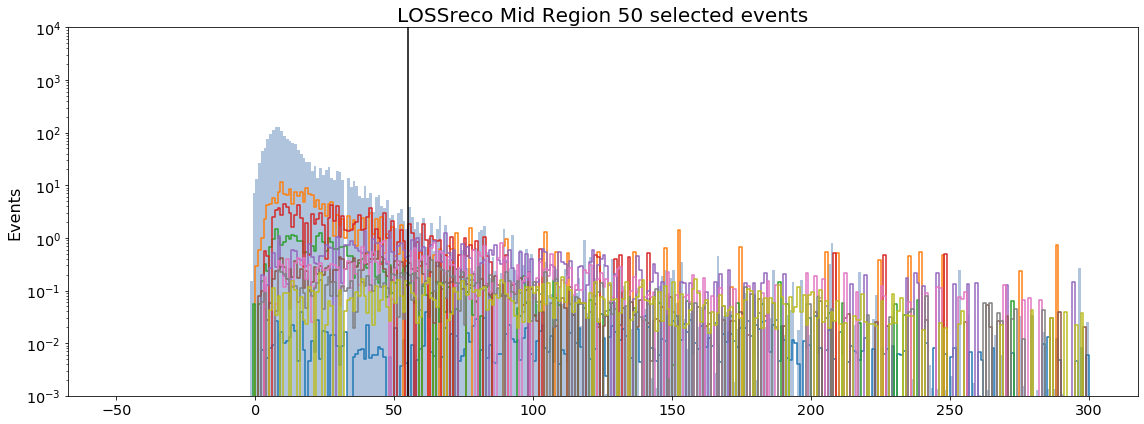

In [32]:
# signal_name_to_plot = ['300_150','500_0','600_150','700_350']

reweight_here = split_val
bin_factor=1
histo_start = -50
histo_end=300
f,a = plt.subplots(1,1, figsize=(16, 6))

start = 0
end = None
    
# color=['purple', 'navy', 'red', 'green', 'black', 'blue']
num_loss = 1
n = 50
density = False

for i,bump_sig_loss in enumerate(bump_sig_loss_list[start:end]):
    i = i + start
    if sig_to_plot:
        if signal_name[i] not in signal_to_plot:
            continue
    histo_range = (histo_start, histo_end)
    bins = int((histo_range[1]-histo_range[0])*bin_factor)
    counts_s, edges_s = np.histogram((bump_sig_loss).astype(float),range=histo_range, bins =bins,
                                    weights=sig_list[i][:,-1]*sig_factor,
                                     density=density
                                    )
    a.step(x=edges_s, y=np.append(counts_s, 0),
            where="post", label='signal_{}'.format(signal_name[i]))

histo_range = (histo_start, histo_end)
bins = int((histo_range[1]-histo_range[0])*bin_factor)

counts_dval, edges_dval = np.histogram((np.array(bump_bkg_loss_v)).astype(float)
                                       ,range=histo_range,
                                       bins =bins*100,
                                            weights=reweight_here*sample_v[:,-1],
                                           density=density) 
                                      
th = (edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)-1]+
            edges_dval[-np.argmax(np.cumsum(counts_dval[::-1])>n)])/2

a.hist((np.array(bump_bkg_loss_v)).astype(float),range=histo_range, bins =bins,
            weights=reweight_here*sample_v[:,-1], 
       stacked=True, 
            density=density,
            color = ['lightsteelblue'], label=['validation_signal_background'])

# a.hist((np.array(val_df_signal_like.loc[:,['loss']])).astype(float),range=histo_range, bins =bins,
#             weights=[val_factor]*np.array(val_df_signal_like.loc[:,['weight']]), 
#        stacked=True, 
#             density=density,
#             color = ['gray'], label=['validation_background_signal_like'])

# if model_dependent:

#     counts_dval, edges_dval = np.histogram((np.array(bump_bkg_only_loss)).astype(float)
#                                            ,range=histo_range,
#                                            bins =bins,
#                                     weights=split_val_bkg_only*val_bkg_only[:,-1],
#                                                density=density) 
    
#     a.step(x=edges_dval, y=np.append(counts_dval, 0),
#             where="post", label='val only backround', color = 'black')
    
a.set_ylabel('Events', fontsize=16)
a.set_title('LOSSreco Mid Region {} selected events'.format(n), fontsize = 20)

a.set_ylim(10**-3,10**4)
a.tick_params(labelsize='x-large')
# a.set_xlim(-5,45)

a.set_yscale('log') 
a.axvline(int(th), color='black')
# lst = [0,5,10,15,th,20,25,30, 35, 40, 45, 50, 60, 70, 80 ,90 ,100, 200, 500, 1000]
# lst = [int(x) for x in lst]
# a.set_xticks(lst)
print(path)

plt.tight_layout()